# Parametric insurance portfolio risk management

Consider a set of $n$ parametric insurance contract with pay out given by $L_1,\ldots, L_n$ associated to a given risk $p_1,\ldots, p_n$. The potential loss associated to such a portfolio is given by 
$$
X = \sum_{k=1}^n I_k l_k,
$$

where $I_1,\ldots, I_n$ is a sequence of $n$ independent Bernouilli random variables of parameters $p_1,\ldots, p_n$. The premium associated to such a portfolio is given by

$$
c = (1+\eta)\sum_{k=1}^n p_k l_k,
$$

where $\eta$ is the loading of the pure premium. 

To emulate such a situation we draw at random the p's and the l's with 
$$
p\sim\text{Unif}(p_{\text{low}},p_{\text{up}})\text{ and }l\sim \text{Unif}(l_{\text{low}},l_{\text{up}})
$$

Let us take

$$
p_{\text{low}} = 0,p_{\text{up}} = 1, l_{\text{low}} = 1\text{, and }l_{\text{up}} = 5.
$$



In [3]:
from loss_distribution import *
from scipy.stats import norm
import seaborn as sns

## Approximation of the 99.5% quantile

We assume that the conttract arrive sequentially in our portfolio, we therefor compute again the dsitribution of $X$ each time a new policy is underwritten and compute the associated solvency capital define as the 99.5% quantile minus the collected premium. 

In [11]:
np.random.seed(50)
n = 50
# Loss amounts (L_k) and probabilities (p_k)
L = np.random.uniform(1, 6, n).astype(int)  # Example loss amounts between 1000 and 5000
p = np.random.uniform(0, 1, n)   # Example probabilities between 0.01 and 0.1``
eta = 0.1  # safety loading

In [12]:
from scipy.stats import norm
results_df = pd.DataFrame(columns=["Method", "k", "SCR", "MCR", "Time"])
R = 10000
I = np.random.binomial(1, p, size=(R, n))
for k in np.arange(2, n+1, 1):

    start_time  = time.time()

    X = np.sum(I[:,:k] * L[:k], axis=1) 
    SCR_simulation = np.quantile(X, 0.995)- (1+eta) * np.sum(L[:k] * p[:k])
    MCR_simulation = np.quantile(X, 0.85)- (1+eta) * np.sum(L[:k] * p[:k])
    time_simulation = time.time() - start_time

    start_time = time.time()
    SCR_normal = norm.ppf(0.995, loc = sum(L[:k] * p[:k]), scale = np.sqrt(sum(L[:k]**2 * p[:k]* (1-p[:k])))) - (1+ eta) * np.sum(L[:k] * p[:k])
    MCR_normal = norm.ppf(0.85, loc = sum(L[:k] * p[:k]), scale = np.sqrt(sum(L[:k]**2 * p[:k]* (1-p[:k])))) - (1+ eta) * np.sum(L[:k] * p[:k])
    time_normal = time.time() - start_time
    

    
    results_df = pd.concat([results_df,
                        pd.DataFrame({"Method": [
                                                "Exact",
                                                   "Normal Approximation"],
                                        "k": [ k, k], 
                                        "SCR": [
                                                SCR_simulation,
                                                 SCR_normal],
                                        "MCR": [
                                                MCR_simulation,
                                                 MCR_normal],
                                        "Time": [
                                                time_simulation, 
                                                 time_normal]})], ignore_index=True)
results_df

,Method,k,SCR,MCR,Time
0,Exact,2,2.669923,2.669923,0.001268
1,Normal Approximation,2,4.111434,1.527720,0.000446
2,Exact,3,3.640662,1.640662,0.001043
3,Normal Approximation,3,4.724320,1.718406,0.000736
4,Exact,4,5.078916,2.078916,0.001272
...,...,...,...,...,...
93,Normal Approximation,48,17.258472,2.080455,0.000412
94,Exact,49,16.430580,1.430580,0.001845
95,Normal Approximation,49,17.045846,1.720750,0.000369
96,Exact,50,16.852250,1.852250,0.001349


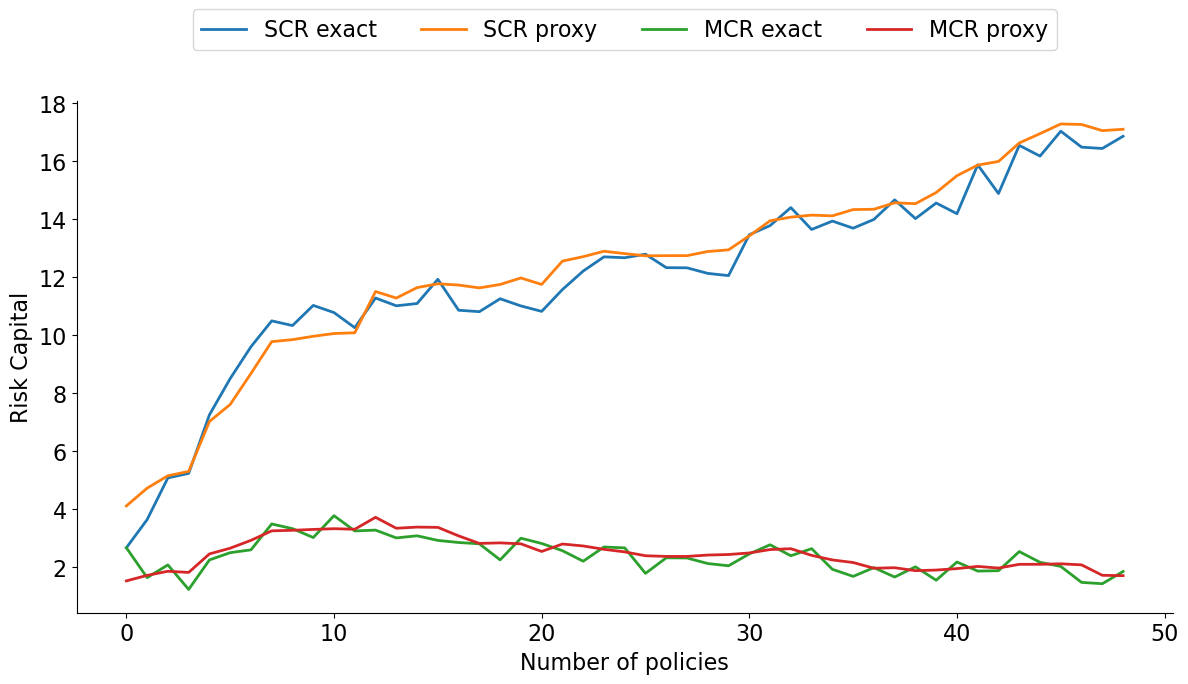

In [13]:
# Set up the figure
plt.figure(figsize=(12, 7))

# Plot SCR with Method as hue
SCR_exact = results_df[results_df["Method"] == "Exact"]["SCR"].values
SCR_normal = results_df[results_df["Method"] == "Normal Approximation"]["SCR"].values
MCR_exact = results_df[results_df["Method"] == "Exact"]["MCR"].values
MCR_normal = results_df[results_df["Method"] == "Normal Approximation"]["MCR"].values
plt.plot(SCR_exact, label = "SCR exact", linestyle='-', linewidth=2)
plt.plot(SCR_normal, label = "SCR proxy", linestyle='-', linewidth=2)

plt.plot(MCR_exact, label = "MCR exact", linestyle='-', linewidth=2)
plt.plot(MCR_normal, label = "MCR proxy", linestyle='-', linewidth=2)

# Customize labels and title
plt.xlabel("Number of policies", fontsize=16)
plt.ylabel("Risk Capital", fontsize=16)
plt.legend(fontsize=16, loc='upper center', bbox_to_anchor=(0.5, 1.20), ncol=4)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


# Remove spines for cleaner look
sns.despine()

# Save the figure
plt.tight_layout()
plt.savefig("../../figures/risk_cap_comparison.pdf")
plt.show()